#installing dependencies

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Wed Nov 17 09:55:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

In [ ]:
!pip install optuna
!pip install seqeval
!pip install sentencepiece
!git clone https://github.com/huggingface/transformers
!cd transformers && pip install .
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 308 kB 8.0 MB/s 
     |████████████████████████████████| 80 kB 12.6 MB/s 
     |████████████████████████████████| 209 kB 58.3 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 91.7 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 144 kB 85.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=eb8f28f4632148fe737177ba6d06a9dd5c30301a95248576712907c787c70222
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=17dd6377be3ad1d5e4561a334b285edc486effc3d6782f70d5e30239c43fc41a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a

#Creating training datasets

In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
all_datasets= []

In [ ]:
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

all_datasets = []

#DzNER corpus

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

`read_ANERcorp` return a list of examples

each example has a list of tokens and a list of corresponding labels

In [ ]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line=='\n':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      if splits[1] != 'ch':
        label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [ ]:
data_train = read_ANERcorp('train.txt')
data_test = read_ANERcorp('test.txt')

print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

label_list = list(Counter([ label for sentence in data_train for label in sentence[1]]).keys())
print(label_list)

Counter({'O': 3222, 'B-LOC': 113, 'B-PERS': 86, 'I-PERS': 24, 'B-ORG': 20, 'I-LOC': 17, 'I-ORG': 16})
Counter({'O': 26331, 'B-PERS': 977, 'B-LOC': 654, 'B-ORG': 260, 'I-PERS': 178, 'I-ORG': 148, 'I-LOC': 43, 'ش': 1})
['O', 'B-LOC', 'B-PERS', 'B-ORG', 'I-ORG', 'I-PERS', 'I-LOC', 'ش']


Training Sentence Lengths: 


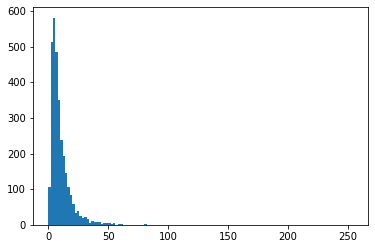

0
Testing Sentence Lengths: 


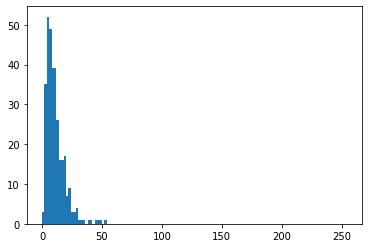

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

256 seems a good choice for max_length

In [ ]:
data_AJGT = Dataset("DzNER", data_train, data_test, label_list)
all_datasets.append(data_AJGT)

#Trainer

In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch
import optuna 

In [ ]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [ ]:
for x in all_datasets:
  print(x.name)

ANERCorp


In [ ]:
dataset_name = 'DzNER'
model_name = 'UBC-NLP/ARBERT'
task_name = 'tokenclassification'

In [ ]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = d
    print('Dataset found')
    break

Dataset found


Create, preprocess, and tokenize ANERCorp

In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, model_name, max_length):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = ArabertPreprocessor(model_name.split("/")[-1])    
    self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_length = max_length

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = self.tokenizer.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = self.tokenizer.num_special_tokens_to_add()
    if len(tokens) > self.max_length - special_tokens_count:
      tokens = tokens[: (self.max_length - special_tokens_count)]
      label_ids = label_ids[: (self.max_length - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [self.tokenizer.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [self.tokenizer.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = self.max_length - len(input_ids)

    input_ids += [self.tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == self.max_length
    assert len(attention_mask) == self.max_length
    assert len(token_type_ids) == self.max_length
    assert len(label_ids) == self.max_length

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }

In [ ]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = NERDataset(
    texts=[x[0] for x in selected_dataset.train],
    tags=[x[1] for x in selected_dataset.train],
    label_list=selected_dataset.label_list,
    model_name=model_name,
    max_length=256
    )

test_dataset = NERDataset(
    texts=[x[0] for x in selected_dataset.test],
    tags=[x[1] for x in selected_dataset.test],
    label_list=selected_dataset.label_list,
    model_name=model_name,
    max_length=256
    )

{'O': 0, 'B-LOC': 1, 'B-PERS': 2, 'B-ORG': 3, 'I-ORG': 4, 'I-PERS': 5, 'I-LOC': 6, 'ش': 7}


DEBUG:filelock:Attempting to acquire lock 140677848022288 on /root/.cache/huggingface/transformers/41d233d78ec59e1817ce96e1283631b3579e030eb979d766e25eaf3e1f0362ff.e2391f37093ecddb817287261d0566d2f027887d636f1764ee422c1977ae6ac1.lock
DEBUG:filelock:Lock 140677848022288 acquired on /root/.cache/huggingface/transformers/41d233d78ec59e1817ce96e1283631b3579e030eb979d766e25eaf3e1f0362ff.e2391f37093ecddb817287261d0566d2f027887d636f1764ee422c1977ae6ac1.lock


Downloading:   0%|          | 0.00/374 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140677848022288 on /root/.cache/huggingface/transformers/41d233d78ec59e1817ce96e1283631b3579e030eb979d766e25eaf3e1f0362ff.e2391f37093ecddb817287261d0566d2f027887d636f1764ee422c1977ae6ac1.lock
DEBUG:filelock:Lock 140677848022288 released on /root/.cache/huggingface/transformers/41d233d78ec59e1817ce96e1283631b3579e030eb979d766e25eaf3e1f0362ff.e2391f37093ecddb817287261d0566d2f027887d636f1764ee422c1977ae6ac1.lock
DEBUG:filelock:Attempting to acquire lock 140679167588752 on /root/.cache/huggingface/transformers/434c80c85742eeafe4ddb060dbfb2ae47dbf7d55834acf27eb1a619e2b7bd311.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11.lock
DEBUG:filelock:Lock 140679167588752 acquired on /root/.cache/huggingface/transformers/434c80c85742eeafe4ddb060dbfb2ae47dbf7d55834acf27eb1a619e2b7bd311.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11.lock


Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140679167588752 on /root/.cache/huggingface/transformers/434c80c85742eeafe4ddb060dbfb2ae47dbf7d55834acf27eb1a619e2b7bd311.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11.lock
DEBUG:filelock:Lock 140679167588752 released on /root/.cache/huggingface/transformers/434c80c85742eeafe4ddb060dbfb2ae47dbf7d55834acf27eb1a619e2b7bd311.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11.lock
DEBUG:filelock:Attempting to acquire lock 140677847981392 on /root/.cache/huggingface/transformers/b666228ad7d67661ab245a67d10a34dfa93d9fd5de5ef3c6a607a92a9db04766.48871a2b1d848c60db4344a74b461797d9913433a790a90861ff76b4e847d1bc.lock
DEBUG:filelock:Lock 140677847981392 acquired on /root/.cache/huggingface/transformers/b666228ad7d67661ab245a67d10a34dfa93d9fd5de5ef3c6a607a92a9db04766.48871a2b1d848c60db4344a74b461797d9913433a790a90861ff76b4e847d1bc.lock


Downloading:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140677847981392 on /root/.cache/huggingface/transformers/b666228ad7d67661ab245a67d10a34dfa93d9fd5de5ef3c6a607a92a9db04766.48871a2b1d848c60db4344a74b461797d9913433a790a90861ff76b4e847d1bc.lock
DEBUG:filelock:Lock 140677847981392 released on /root/.cache/huggingface/transformers/b666228ad7d67661ab245a67d10a34dfa93d9fd5de5ef3c6a607a92a9db04766.48871a2b1d848c60db4344a74b461797d9913433a790a90861ff76b4e847d1bc.lock
DEBUG:filelock:Attempting to acquire lock 140677848020688 on /root/.cache/huggingface/transformers/110b3bd85e0675de74f72d1ba2e29b31cd09cd69aa8f70d9037b706f3bcc26fb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
DEBUG:filelock:Lock 140677848020688 acquired on /root/.cache/huggingface/transformers/110b3bd85e0675de74f72d1ba2e29b31cd09cd69aa8f70d9037b706f3bcc26fb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140677848020688 on /root/.cache/huggingface/transformers/110b3bd85e0675de74f72d1ba2e29b31cd09cd69aa8f70d9037b706f3bcc26fb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
DEBUG:filelock:Lock 140677848020688 released on /root/.cache/huggingface/transformers/110b3bd85e0675de74f72d1ba2e29b31cd09cd69aa8f70d9037b706f3bcc26fb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 7.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=adb956a132dadcdb3906d19cfe3e046792fa5e3171414f0e20f1dafffdddacf2
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


Get NER Model

In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != torch.nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(p):
    preds_list, out_label_list = align_predictions(p.predictions,p.label_ids)
    #print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

#Regular Training

In [ ]:
training_args = TrainingArguments("./train")
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 3.0000000000000004e-05
training_args.fp16 = True
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 16
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 15


steps_per_epoch = (len(selected_dataset.train)// (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps))
total_steps = steps_per_epoch * training_args.num_train_epochs
print(steps_per_epoch)
print(total_steps)
#Warmup_ratio
warmup_ratio = 0.1
training_args.warmup_steps = 42
#total_steps*warmup_ratio

training_args.evaluation_strategy = EvaluationStrategy.EPOCH
# training_args.logging_steps = 200
training_args.save_steps = 100000 #don't want to save any model
training_args.seed = 12345
training_args.disable_tqdm = False
training_args.lr_scheduler_type = 'cosine'

96
1440


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

DEBUG:filelock:Attempting to acquire lock 140677843098192 on /root/.cache/huggingface/transformers/f37a41178e5c357491b1adb9fe079d6e41ff54338328ea61fbd2a155b6c782ea.ef8eca7a93e9680c24baaba838665035caca0660ec8613de69adea7f19b57817.lock
DEBUG:filelock:Lock 140677843098192 acquired on /root/.cache/huggingface/transformers/f37a41178e5c357491b1adb9fe079d6e41ff54338328ea61fbd2a155b6c782ea.ef8eca7a93e9680c24baaba838665035caca0660ec8613de69adea7f19b57817.lock


Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140677843098192 on /root/.cache/huggingface/transformers/f37a41178e5c357491b1adb9fe079d6e41ff54338328ea61fbd2a155b6c782ea.ef8eca7a93e9680c24baaba838665035caca0660ec8613de69adea7f19b57817.lock
DEBUG:filelock:Lock 140677843098192 released on /root/.cache/huggingface/transformers/f37a41178e5c357491b1adb9fe079d6e41ff54338328ea61fbd2a155b6c782ea.ef8eca7a93e9680c24baaba838665035caca0660ec8613de69adea7f19b57817.lock
Some weights of the model checkpoint at UBC-NLP/ARBERT were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with anothe

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 3078
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1440


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1440, training_loss=0.03771715274908476, metrics={'train_runtime': 1289.3847, 'train_samples_per_second': 35.808, 'train_steps_per_second': 1.117, 'total_flos': 6031578908049408.0, 'train_loss': 0.03771715274908476, 'epoch': 14.99})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 327
  Batch size = 16


{'epoch': 14.99,
 'eval_accuracy_score': 0.9762721555174385,
 'eval_f1': 0.8232558139534883,
 'eval_loss': 0.17663879692554474,
 'eval_precision': 0.8388625592417062,
 'eval_recall': 0.8082191780821918,
 'eval_runtime': 5.4461,
 'eval_samples_per_second': 60.043,
 'eval_steps_per_second': 3.856}

In [ ]:
trainer.save_model("SOME_PATH")

Saving model checkpoint to SOME_PATH
Configuration saved in SOME_PATH/config.json
Model weights saved in SOME_PATH/pytorch_model.bin
